# Plot end of century seasonal temperature

In [1]:
# Import functions
import warnings 
warnings.filterwarnings('ignore')
import os
import iris
import iris.cube
import cf_units
import numpy as np
import numpy.ma as ma
import xarray as xr
import regionmask
from scipy import stats
import iris.plot as iplt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.cm as mpl_cm
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec

ERROR 1: PROJ: proj_create_from_database: Open of /home/h05/awells/.conda/envs/env/share/proj failed


## Load and process DJF temp data

In [2]:
# file path
path = '/data/users/awells/geoMIP/processed_data/UKESM1_Monthly_temp_full_'

ssp245 = xr.open_dataarray(path + 'ssp245_2020-2100.nc')
ssp585 = xr.open_dataarray(path + 'ssp585_2020-2100.nc')
#g6con = xr.open_dataarray(path + 'G6controller_2020-2100.nc')
g6sulf = xr.open_dataarray(path + 'G6sulfur_2020-2100.nc')

Calculate end of century average and ensemble mean

In [3]:
djf_ssp245 = ssp245.sel(time=ssp245.time.dt.season=='DJF').mean(dim=('time', 'realization'))
djf_ssp245_std = ssp245.sel(time=ssp245.time.dt.season=='DJF').std('time').mean('realization')
djf_ssp585 = ssp585.sel(time=ssp585.time.dt.season=='DJF').mean(dim=('time', 'realization'))
#djf_g6con = g6con.sel(time=g6con.time.dt.season=='DJF').mean(dim=('time', 'realization'))
djf_g6sulf = g6sulf.sel(time=g6sulf.time.dt.season=='DJF').mean(dim=('time', 'realization'))

In [6]:
jja_ssp245 = ssp245.sel(time=ssp245.time.dt.season=='JJA').mean(dim=('time', 'realization'))
jja_ssp245_std = ssp245.sel(time=ssp245.time.dt.season=='JJA').std('time').mean('realization')
jja_ssp585 = ssp585.sel(time=ssp585.time.dt.season=='JJA').mean(dim=('time', 'realization'))
#jja_g6con = g6con.sel(time=g6con.time.dt.season=='JJA').mean(dim=('time', 'realization'))
jja_g6sulf = g6sulf.sel(time=g6sulf.time.dt.season=='JJA').mean(dim=('time', 'realization'))

Convert longitude 

In [7]:
def adjust_longitude(dataset: xr.Dataset) -> xr.Dataset:
        """Swaps longitude coordinates from range (0, 360) to (-180, 180)
        Args:
            dataset (xr.Dataset): xarray Dataset
        Returns:
            xr.Dataset: xarray Dataset with swapped longitude dimensions
        """
        lon_name = "longitude"  # whatever name is in the data

        # Adjust lon values to make sure they are within (-180, 180)
        dataset["_longitude_adjusted"] = xr.where(
            dataset[lon_name] > 180, dataset[lon_name] - 360, dataset[lon_name])
        dataset = (
            dataset.swap_dims({lon_name: "_longitude_adjusted"})
            .sel(**{"_longitude_adjusted": sorted(dataset._longitude_adjusted)})
            .drop(lon_name)
        )

        dataset = dataset.rename({"_longitude_adjusted": lon_name})
        return dataset

djf_ssp245_mean = adjust_longitude(djf_ssp245)
djf_ssp245_std = adjust_longitude(djf_ssp245_std)
djf_ssp585_mean = adjust_longitude(djf_ssp585)
#djf_g6con_mean = adjust_longitude(djf_g6con)
djf_g6sulf_mean = adjust_longitude(djf_g6sulf)

jja_ssp245_mean = adjust_longitude(jja_ssp245)
jja_ssp245_std = adjust_longitude(jja_ssp245_std)
jja_ssp585_mean = adjust_longitude(jja_ssp585)
#jja_g6con_mean = adjust_longitude(jja_g6con)
jja_g6sulf_mean = adjust_longitude(jja_g6sulf)

Remove ocean

In [8]:
landfrac = iris.load_cube('/home/h05/awells/geoMIP/plotting/land_fraction.pp')
lf = adjust_longitude(xr.DataArray.from_iris(landfrac))

djf_ssp245_land = djf_ssp245_mean.where(lf >= 0.5)
djf_ssp245_std_land = djf_ssp245_std.where(lf >= 0.5)
djf_ssp585_land = djf_ssp585_mean.where(lf >= 0.5)
#djf_g6con_land = djf_g6con_mean.where(lf >= 0.5)
djf_g6sulf_land = djf_g6sulf_mean.where(lf >= 0.5)

jja_ssp245_land = jja_ssp245_mean.where(lf >= 0.5)
jja_ssp245_std_land = jja_ssp245_std.where(lf >= 0.5)
jja_ssp585_land = jja_ssp585_mean.where(lf >= 0.5)
#jja_g6con_land = jja_g6con_mean.where(lf >= 0.5)
jja_g6sulf_land = jja_g6sulf_mean.where(lf >= 0.5)

Calculate regional temperatures

In [9]:
ar6_land = regionmask.defined_regions.ar6.land
mask_3D = ar6_land.mask_3D(djf_ssp245_mean.longitude, djf_ssp245_mean.latitude)

In [10]:
weights = np.cos(np.deg2rad(djf_ssp245_mean.latitude))

djf_ssp245_regional = djf_ssp245_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
djf_ssp245_std_regional = djf_ssp245_std_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
djf_ssp585_regional = djf_ssp585_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
djf_g6sulf_regional = djf_g6sulf_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
#djf_g6con_regional = djf_g6con_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))

jja_ssp245_regional = jja_ssp245_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
jja_ssp245_std_regional = jja_ssp245_std_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
jja_ssp585_regional = jja_ssp585_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
jja_g6sulf_regional = jja_g6sulf_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))
#jja_g6con_regional = jja_g6con_land.weighted(mask_3D * weights).mean(dim=('latitude', 'longitude'))

In [12]:
djf_g6sulf_miss = np.where(np.logical_or((djf_g6sulf_regional - djf_ssp245_regional) > djf_ssp245_std_regional, (djf_g6sulf_regional - djf_ssp245_regional) < -djf_ssp245_std_regional))[0]
#djf_g6con_miss = np.where(np.logical_or((djf_g6con_regional - djf_ssp245_regional) > djf_ssp245_std_regional, (djf_g6con_regional - djf_ssp245_regional) < -djf_ssp245_std_regional))[0]

djf_g6sulf_regions = ar6_land[djf_g6sulf_miss.tolist()]
#djf_g6con_regions = ar6_land[djf_g6con_miss.tolist()]

In [13]:
jja_g6sulf_miss = np.where(np.logical_or((jja_g6sulf_regional - jja_ssp245_regional) > jja_ssp245_std_regional, (jja_g6sulf_regional - jja_ssp245_regional) < -jja_ssp245_std_regional))[0]
#jja_g6con_miss = np.where(np.logical_or((jja_g6con_regional - jja_ssp245_regional) > jja_ssp245_std_regional, (jja_g6con_regional - jja_ssp245_regional) < -jja_ssp245_std_regional))[0]

jja_g6sulf_regions = ar6_land[jja_g6sulf_miss.tolist()]
#jja_g6con_regions = ar6_land[jja_g6con_miss.tolist()]

## Calculate statistical significance - DJF

In [17]:
djf_ssp245_r = ssp245.sel(time=ssp245.time.dt.season=='DJF').sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(ssp245.realization)):
    djf_ssp245_r = xr.concat((djf_ssp245_r, ssp245.sel(time=ssp245.time.dt.season=='DJF').sel(time=slice('2081','2101')).sel(realization=i)), dim='time')

djf_g6sulf_r = g6sulf.sel(time=g6sulf.time.dt.season=='DJF').sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(g6sulf.realization)):
    djf_g6sulf_r = xr.concat((djf_g6sulf_r, g6sulf.sel(time=g6sulf.time.dt.season=='DJF').sel(time=slice('2081','2101')).sel(realization=i)), dim='time')
    
#djf_g6con_r = g6con.sel(time=g6con.time.dt.season=='DJF').sel(time=slice('2081','2101')).sel(realization=0)
#for i in range(1, len(g6con.realization)):
#    djf_g6con_r = xr.concat((djf_g6con_r, g6con.sel(time=g6con.time.dt.season=='DJF').sel(time=slice('2081','2101')).sel(realization=i)), dim='time')


In [18]:
stat, pval = stats.ttest_ind(djf_g6sulf_r, djf_ssp245_r)
djf_pval_g6sulf = adjust_longitude(xr.DataArray(data=pval, 
                     dims=['latitude', 'longitude'], 
                     coords=dict(longitude=(['longitude'], djf_ssp245_r.longitude.values), 
                                 latitude=(['latitude'], djf_ssp245_r.latitude.values))))

#stat, pval = stats.ttest_ind(djf_g6con_r, djf_ssp245_r)
#djf_pval_g6con = adjust_longitude(xr.DataArray(data=pval, 
#                     dims=['latitude', 'longitude'], 
#                     coords=dict(longitude=(['longitude'], djf_ssp245_r.longitude.values), 
#                                 latitude=(['latitude'], djf_ssp245_r.latitude.values))))

## Calculate statistical significance - JJA

In [19]:
jja_ssp245_r = ssp245.sel(time=ssp245.time.dt.season=='JJA').sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(ssp245.realization)):
    jja_ssp245_r = xr.concat((jja_ssp245_r, ssp245.sel(time=ssp245.time.dt.season=='JJA').sel(time=slice('2081','2101')).sel(realization=i)), dim='time')

jja_g6sulf_r = g6sulf.sel(time=g6sulf.time.dt.season=='JJA').sel(time=slice('2081','2101')).sel(realization=0)
for i in range(1, len(g6sulf.realization)):
    jja_g6sulf_r = xr.concat((jja_g6sulf_r, g6sulf.sel(time=g6sulf.time.dt.season=='JJA').sel(time=slice('2081','2101')).sel(realization=i)), dim='time')
    
#jja_g6con_r = g6con.sel(time=g6con.time.dt.season=='JJA').sel(time=slice('2081','2101')).sel(realization=0)
#for i in range(1, len(g6con.realization)):
#    jja_g6con_r = xr.concat((jja_g6con_r, g6con.sel(time=g6con.time.dt.season=='JJA').sel(time=slice('2081','2101')).sel(realization=i)), dim='time')
    

In [20]:
stat, pval = stats.ttest_ind(jja_g6sulf_r, jja_ssp245_r)
jja_pval_g6sulf = adjust_longitude(xr.DataArray(data=pval, 
                     dims=['latitude', 'longitude'], 
                     coords=dict(longitude=(['longitude'], jja_ssp245_r.longitude.values), 
                                 latitude=(['latitude'], jja_ssp245_r.latitude.values))))

#stat, pval = stats.ttest_ind(jja_g6con_r, jja_ssp245_r)
#jja_pval_g6con = adjust_longitude(xr.DataArray(data=pval, 
#                     dims=['latitude', 'longitude'], 
#                     coords=dict(longitude=(['longitude'], jja_ssp245_r.longitude.values), 
#                                latitude=(['latitude'], jja_ssp245_r.latitude.values))))

## Plotting

In [14]:
params = {'legend.fontsize': 20,
          'axes.labelsize': 30,
          'axes.titlesize': 35,
          'axes.linewidth': 8,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'axes.grid': True}

plt.rcParams.update(params)

def autosize_figure(nrows, ncolumns, scale_factor=1, xscale_factor=1, yscale_factor=1):
    xwidth = (ncolumns+0.67) * 5.0 * scale_factor * xscale_factor
    ylength = (nrows+0.67) * 3.6 * scale_factor * yscale_factor
    return (xwidth, ylength)

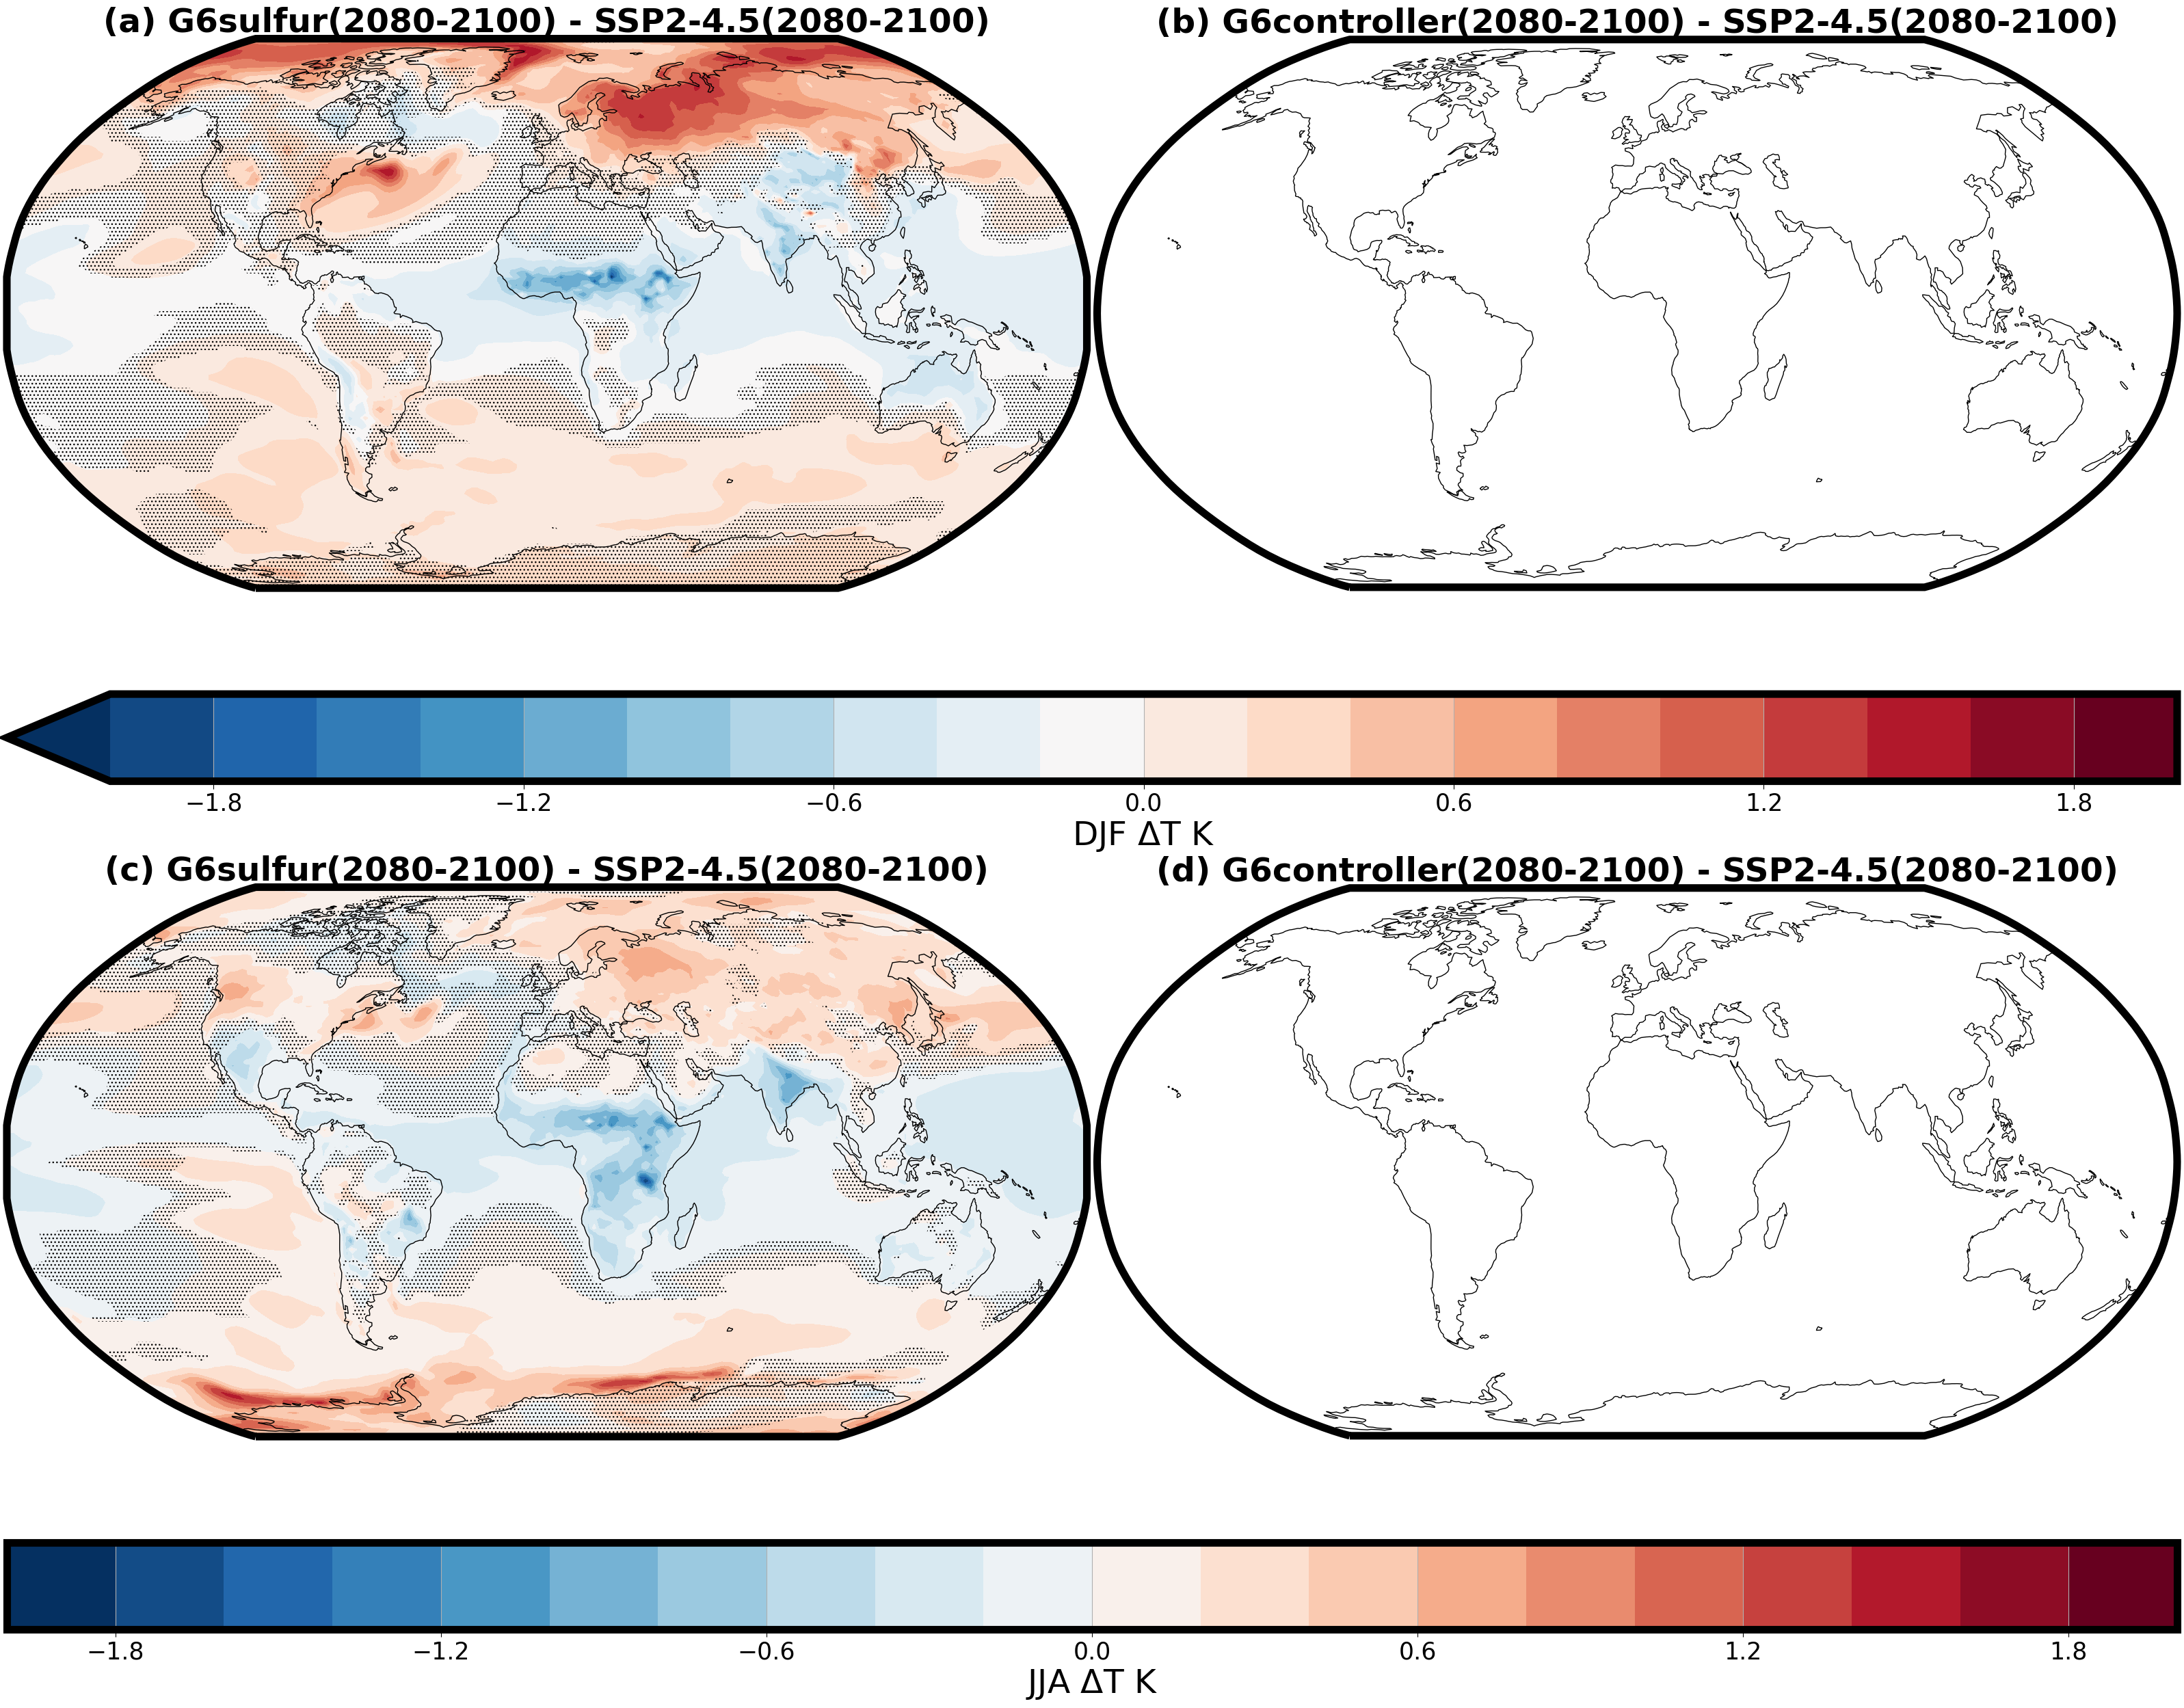

In [31]:
col_map = mpl_cm.get_cmap('RdBu_r')
projection = ccrs.Robinson()
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=autosize_figure(2, 2, scale_factor=2.4, yscale_factor=1.1))
gs = GridSpec(4, 2, height_ratios=[15, 2, 15, 2])

lvs = np.linspace(-2, 2, 21)

ax2 = fig.add_subplot(gs[0, 0], projection=projection, frameon=True)
cb1 = (djf_g6sulf_mean - djf_ssp245_mean).plot.contourf(transform=crs, cmap=col_map, levels=lvs, add_colorbar=False, subplot_kws={'projection':projection})
if np.any(djf_g6sulf_regions) != False:
    djf_g6sulf_regions.plot(add_label=False)
djf_pval_g6sulf.where(djf_pval_g6sulf>0.05).plot.contourf(transform=crs, colors='none', levels=[0,1], hatches=['...'], add_colorbar=False, subplot_kws={'projection':projection})
ax2.coastlines()
plt.title('(a) G6sulfur(2080-2100) - SSP2-4.5(2080-2100)', fontweight='bold')

ax3 = fig.add_subplot(gs[0, 1], projection=projection, frameon=True)
#cb1 = (djf_g6con_mean - djf_ssp245_mean).plot.contourf(transform=crs, cmap=col_map, levels=lvs, add_colorbar=False, subplot_kws={'projection':projection})
#if np.any(djf_g6con_regions) != False:
#    djf_g6con_regions.plot(add_label=False)
#djf_pval_g6con.where(djf_pval_g6con>0.05).plot.contourf(transform=crs, colors='none', levels=[0,1], hatches=['...'], add_colorbar=False, subplot_kws={'projection':projection})
ax3.coastlines()
plt.title('(b) G6controller(2080-2100) - SSP2-4.5(2080-2100)', fontweight='bold')

cax1 = fig.add_subplot(gs[1, :])
col_bar = plt.colorbar(cb1, cax=cax1, orientation='horizontal')
col_bar.set_label('DJF $\Delta$T K', fontsize=35)

ax3 = fig.add_subplot(gs[2, 0], projection=projection, frameon=True)
cb2 = (jja_g6sulf_mean - jja_ssp245_mean).plot.contourf(transform=crs, cmap=col_map, levels=lvs, add_colorbar=False, subplot_kws={'projection':projection})
if np.any(jja_g6sulf_regions) != False:
    jja_g6sulf_regions.plot(add_label=False)
jja_pval_g6sulf.where(jja_pval_g6sulf>0.05).plot.contourf(transform=crs, colors='none', levels=[0,1], hatches=['...'], add_colorbar=False, subplot_kws={'projection':projection})
ax3.coastlines()
plt.title('(c) G6sulfur(2080-2100) - SSP2-4.5(2080-2100)', fontweight='bold')

ax4 = fig.add_subplot(gs[2, 1], projection=projection, frameon=True)
#cb2 = (jja_g6con_mean - jja_ssp245_mean).plot.contourf(transform=crs, cmap=col_map, levels=lvs, add_colorbar=False, subplot_kws={'projection':projection})
#if np.any(jja_g6con_regions) != False:
#    jja_g6con_regions.plot(add_label=False)
#jja_pval_g6con.where(jja_pval_g6con>0.05).plot.contourf(transform=crs, colors='none', levels=[0,1], hatches=['...'], add_colorbar=False, subplot_kws={'projection':projection})
ax4.coastlines()
plt.title('(d) G6controller(2080-2100) - SSP2-4.5(2080-2100)', fontweight='bold')

cax2 = fig.add_subplot(gs[3, :])
col_bar = plt.colorbar(cb2, cax=cax2, orientation='horizontal')
col_bar.set_label('JJA $\Delta$T K', fontsize=35)

plt.tight_layout()
plt.savefig('/net/home/h05/awells/PycharmProjects/G6_comparison/Plots/Wells2023/FigureS2.png', dpi=200)
plt.show()